## SRME2 + SRME1+2

![SRME method](../images/SRME_method.png)

This notebook is an implementation of SRME2 and SRME1+SRME2

Reference:
1. (https://github.com/DIG-Kaust/Adaptive-subtraction/blob/master/notebooks/Multiples_Prediction.ipynb)
2. [多次波分离与成像方法研究-李志娜-博士论文](http://kns-cnki-net-s.vpn.cdut.edu.cn:8118/kcms2/article/abstract?v=1i9K2Vab0pPLZfwCMX6yR0lFRhl6QO2DKjIUz3H8b10Lji36qmhb8E8bKAbLRZ5EDhgr65mEMr_4fNxMaFctnC4_X5WxoagzEO2l77J9TEoUm6H5kYczH_aeVVOO4BXA48NEWG692VKMWUGkh5Md6Q==&uniplatform=NZKPT&language=CHS)

###  1. Using the output of SRME as a positive focus transformation operator

将SRME的输出作为正聚焦变换算子，通过正聚焦变换将一次波能量聚焦在原点附近的区域内，同时将一阶多次波转化为一次波，将高阶多次波转化为比其低一阶的多次波

正聚焦变换：
$$
Q = FP
$$

反聚焦变换：
$$
\hat{P} = GQ
$$

其中，$F = G^{-1}$，聚焦变换可以定义为每个空间频率分量上矩阵的相乘，P为原始数据矩阵，对于$F$，则有：
$$
G = \Delta \hat{P} \\

F = [\Delta \hat{P}] \approx \Delta \hat{P}^{H} B \\ 

B = [\Delta P \Delta P^{H} + \epsilon^2 I]^{-1}
$$

其中，与$(\Delta P^{H})B$相乘意味着加权互相关，加权算子为矩阵B，在加权互相关处理过程中，所有的炮记录都对单道输出有贡献，$\epsilon$和$I$分别为数值稳定正常数和单位矩阵

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
import pylops
import sys
sys.path.append('../')
plt.style.use('default')

/home/wwd/miniconda3/envs/pytorch1_13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = np.load('../data/data_free.npz')['arr_0']
data = data[:, :, :800]

ns = data.shape[0]  # number of sources
nr = data.shape[1]  # receivers
nt = data.shape[2]  # time sample

dt = 1              # time interval (ms)
dx = 12             # space interval (m)
isrc = (ns // 2)+1  # middle source
data.shape

(101, 101, 800)

In [3]:
from uilts.mutter import mutter

data_mutter = np.zeros_like(data)
input = data.copy()
for index in range(ns):
    # depth : 5m
    # the first layer velocity: 3km/s
    # the delta : 100
    data_mutter[index, :, :] = mutter(input[index, :, :], index, 5, 3, 3, 100)

In [4]:
lsqr_prim_p = np.load('../data/lsqr_prim_p.npz')['arr_0']
lsqr_prim_t = np.load('../data/lsqr_prim_t.npz')['arr_0']

print(data_mutter.shape)
print(lsqr_prim_p.shape)
print(lsqr_prim_t.shape)

# Focusing transformation requires the same number of firing points and receiving points
# 聚焦变换要求炮点数和接收点个数相同(由于窗口大小的限制, 因此要对炮点个数进行截断)
nr = lsqr_prim_t.shape[1]

data_mutter = data_mutter[:nr, :nr, :]
lsqr_prim_p = lsqr_prim_p[:nr, :, :]
lsqr_prim_t = lsqr_prim_t[:nr, :, :]

print(data_mutter.shape)
print(lsqr_prim_p.shape)
print(lsqr_prim_t.shape)

(101, 101, 800)
(101, 99, 800)
(101, 99, 800)
(99, 99, 800)
(99, 99, 800)
(99, 99, 800)


In [5]:
from uilts.focal_transform import focal_transform_forward
from uilts.focal_transform import focal_transform_inverse

focal_forward_p = focal_transform_forward(data_mutter, lsqr_prim_p, 1e1)
focal_inverse_p = focal_transform_inverse(focal_forward_p, lsqr_prim_p, 1e-2)

inverse: 100%|█████████████████████████████████████████████████| 1025/1025 [00:02<00:00, 453.17it/s]


In [6]:
focal_forward_t = focal_transform_forward(data_mutter, lsqr_prim_t, 1e1)
focal_inverse_t = focal_transform_inverse(focal_forward_t, lsqr_prim_t, 1e-2)

inverse: 100%|█████████████████████████████████████████████████| 1025/1025 [00:02<00:00, 398.11it/s]


(np.float64(0.0), np.float64(99.0), np.float64(0.8), np.float64(0.0))

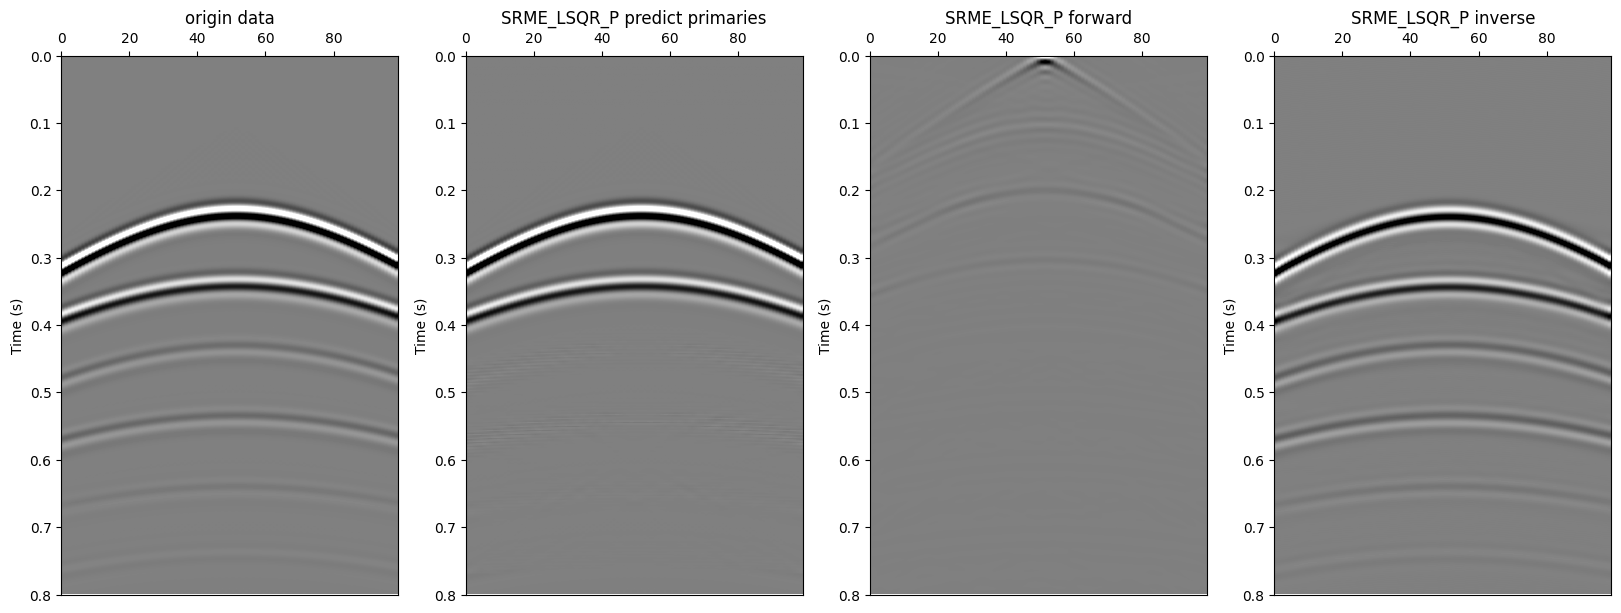

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(20, 7))
pclip = 0.5
axs[0].imshow(
    data_mutter[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(data_mutter[isrc, :, :]).max(),
    vmax=pclip * np.abs(data_mutter[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[0].set(ylabel="Time (s)", title="origin data")
axs[0].xaxis.set_ticks_position('top')
axs[0].axis("tight")

axs[1].imshow(
    lsqr_prim_p[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(lsqr_prim_p[isrc, :, :]).max(),
    vmax=pclip * np.abs(lsqr_prim_p[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[1].set(ylabel="Time (s)", title="SRME_LSQR_P predict primaries")
axs[1].xaxis.set_ticks_position('top')
axs[1].axis("tight")

axs[2].imshow(
    focal_forward_p[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(focal_forward_p[isrc, :, :]).max(),
    vmax=pclip * np.abs(focal_forward_p[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[2].set(ylabel="Time (s)", title="SRME_LSQR_P forward")
axs[2].xaxis.set_ticks_position('top')
axs[2].axis("tight")

axs[3].imshow(
    focal_inverse_p[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(focal_inverse_p[isrc, :, :]).max(),
    vmax=pclip * np.abs(focal_inverse_p[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[3].set(ylabel="Time (s)", title="SRME_LSQR_P inverse")
axs[3].xaxis.set_ticks_position('top')
axs[3].axis("tight")

(np.float64(0.0), np.float64(99.0), np.float64(0.8), np.float64(0.0))

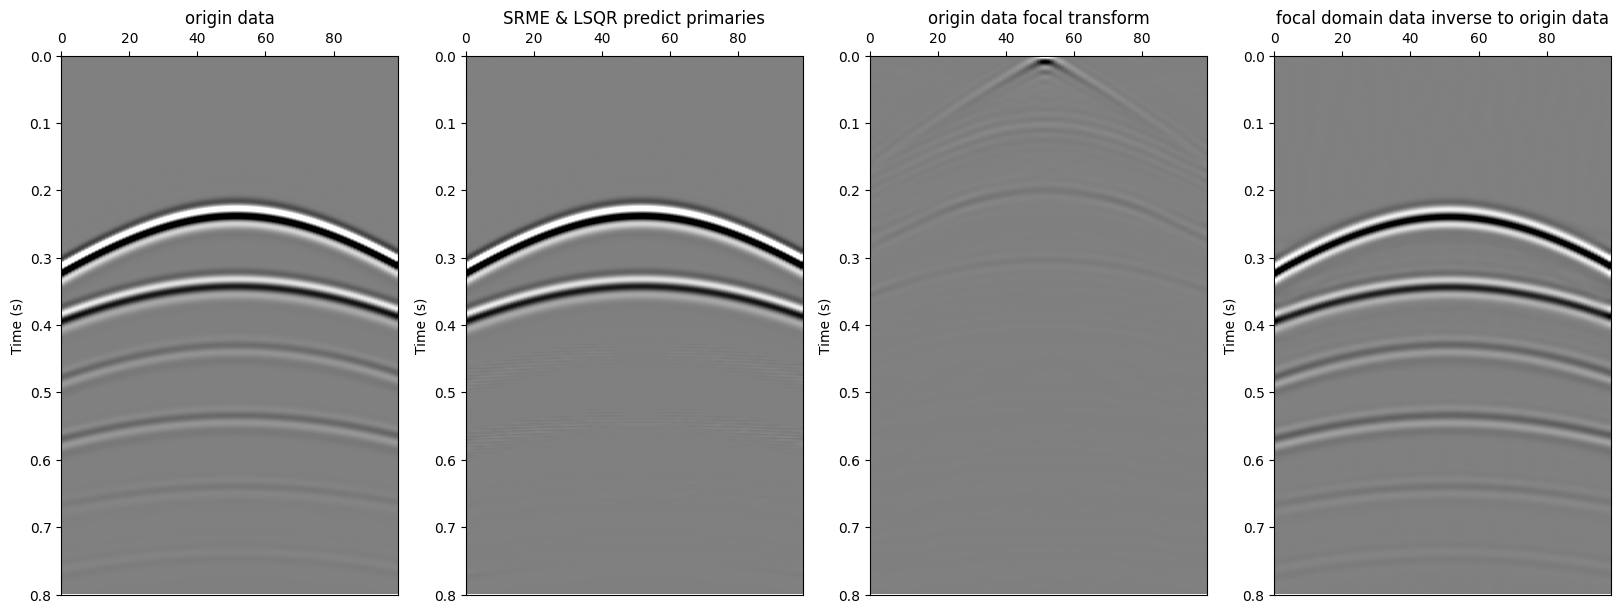

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(20, 7))
axs[0].imshow(
    data_mutter[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(data_mutter[isrc, :, :]).max(),
    vmax=pclip * np.abs(data_mutter[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[0].set(ylabel="Time (s)", title="origin data")
axs[0].xaxis.set_ticks_position('top')
axs[0].axis("tight")

axs[1].imshow(
    lsqr_prim_t[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(lsqr_prim_t[isrc, :, :]).max(),
    vmax=pclip * np.abs(lsqr_prim_t[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[1].set(ylabel="Time (s)", title="SRME & LSQR predict primaries")
axs[1].xaxis.set_ticks_position('top')
axs[1].axis("tight")

axs[2].imshow(
    focal_forward_t[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(focal_forward_t[isrc, :, :]).max(),
    vmax=pclip * np.abs(focal_forward_t[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[2].set(ylabel="Time (s)", title="origin data focal transform")
axs[2].xaxis.set_ticks_position('top')
axs[2].axis("tight")

axs[3].imshow(
    focal_inverse_t[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(focal_inverse_t[isrc, :, :]).max(),
    vmax=pclip * np.abs(focal_inverse_t[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[3].set(ylabel="Time (s)", title="focal domain data inverse to origin data")
axs[3].xaxis.set_ticks_position('top')
axs[3].axis("tight")

### 2. Separation of primary and multiple waves

将时空域数据变换到聚焦域后，需要将一次波与多次波进行分离，再进行反变换到时空域，得到一次波和多次波，方法如下

1. (1) 在聚焦变换域内将一次波与多次波进行分离，通过反聚焦变换返回原始数据域得到直接分离的一次波和多次波


2. (2) 聚焦变换域内将多次波转化为一次波，去掉聚焦变换域内的一次波能量，在聚焦变换域内将由多次波恢复的类似原始记录的波场直接作为初始数据进行利用


#### 2.1 直接将多次波与一次波分离

在将原始数据进行正聚焦转换之后，一次波将转换为在时间$t=0$周围的一聚焦点$\hat{I}$将聚焦点附近的带限聚焦能量与其他的反射能量区分开，然后应用反 聚焦变换就可以得到分离的一次波，用原始数据减去分离的一次波即可获取分离的多次波。这个过程可以通过如下四步进行：

1. 正聚焦变换：
$$
Q = FP = \hat{I} + \hat{A}P', 其中 F \approx \Delta P^{H} B
$$
对原始数据进行正聚焦变换后，一次波映射到聚焦域内t=0附近的聚焦点，而多次 波则映射为具有原始数据形态的新记录

2. 聚焦变换域内成像：
$$
\Delta Q = \hat{I}
$$
(1) 映射到$\tau-p$域，可将与角度有关的一次波信息置于$\tau=0$处

(2) 通过简单的切除函数

(3) 最小二乘相减方法，有下式： 
$$
\Delta Q = Q - F_{ls}P
$$

3. 反聚焦变换：
$$
\Delta P = G \Delta Q, 其中G = \Delta \hat{P}
$$
对分离出来的聚焦区域的能量应用反聚焦变换，就可以得到一次波响应(分离出来的聚焦区域的多次波，通过反变化为时空域的一次波)

4. 多次波分离
$$
M = P - \Delta P
$$

将分离出来的一次波从原始数据中减去，即可获得分离后的多次波

In [9]:
focal_isrc_p = focal_forward_p[isrc, :, :]
focal_isrc_t = focal_forward_t[isrc, :, :]

In [10]:
# 1.1 Pylops linear Radon

nfft = int(2 ** np.ceil(np.log2(nt)))
print(nfft)
nx = data_mutter.shape[0]
npx, pxmax = 8 * nx, 2e-3
px = np.linspace(-pxmax, pxmax, npx)

taxis = np.arange(nt) * dt * 1e-3
xaxis = np.arange(nx) * dx

R2Op = pylops.signalprocessing.FourierRadon2D(
    taxis, xaxis, px, nfft, kind="linear", engine="numpy", dtype="float64"
)

dL_p = R2Op.H * focal_isrc_p
dL_t = R2Op.H * focal_isrc_t

dL_p_inverse = R2Op * dL_p
dL_t_inverse = R2Op * dL_t

dL_p.shape

1024


(792, 800)

(np.float64(-0.5), np.float64(98.5), np.float64(799.5), np.float64(-0.5))

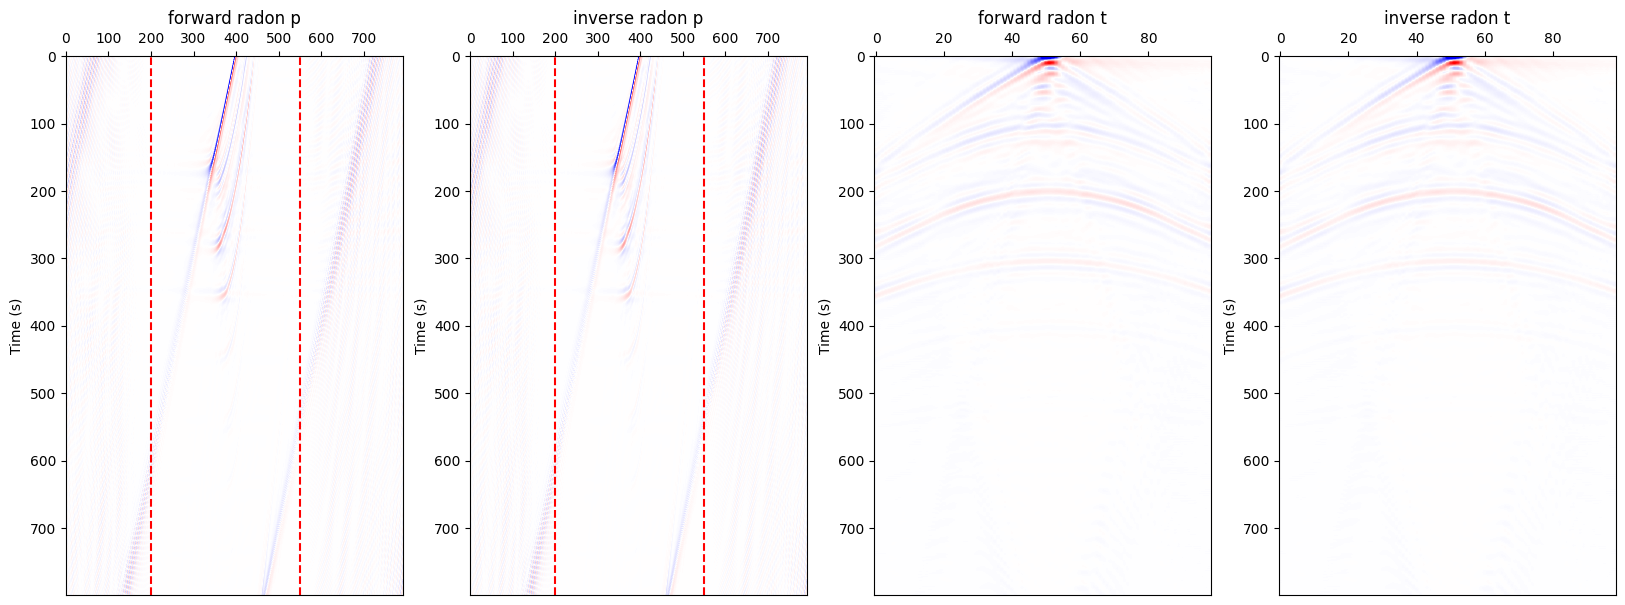

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(20, 7))
axs[0].imshow(
    dL_p.T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(dL_p).max(),
    vmax=pclip * np.abs(dL_p).max(),
)
axs[0].set(ylabel="Time (s)", title="forward radon p")
axs[0].xaxis.set_ticks_position('top')
axs[0].axis("tight")
axs[0].axvline(200, color="r", linestyle="--")
axs[0].axvline(550, color="r", linestyle="--")

axs[1].imshow(
    dL_t.T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(dL_t).max(),
    vmax=pclip * np.abs(dL_t).max(),
)
axs[1].set(ylabel="Time (s)", title="inverse radon p")
axs[1].xaxis.set_ticks_position('top')
axs[1].axis("tight")
axs[1].axvline(200, color="r", linestyle="--")
axs[1].axvline(550, color="r", linestyle="--")

axs[2].imshow(
    dL_p_inverse.T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(dL_p_inverse).max(),
    vmax=pclip * np.abs(dL_p_inverse).max(),
)
axs[2].set(ylabel="Time (s)", title="forward radon t")
axs[2].xaxis.set_ticks_position('top')
axs[2].axis("tight")

axs[3].imshow(
    dL_t_inverse.T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(dL_t_inverse).max(),
    vmax=pclip * np.abs(dL_t_inverse).max(),
)
axs[3].set(ylabel="Time (s)", title="inverse radon t")
axs[3].xaxis.set_ticks_position('top')
axs[3].axis("tight")

In [12]:
def radon_filter(data, left, right):
    output = np.zeros_like(data) 
    output[:, left: right] = data[:, left: right]
    return output

In [13]:
dL_p_filter = radon_filter(dL_p.T, 200, 550)
dL_t_filter = radon_filter(dL_t.T, 200, 550)

dL_p_inverse_filter = R2Op * dL_p_filter.T
dL_t_inverse_filter = R2Op * dL_t_filter.T

(np.float64(-0.5), np.float64(98.5), np.float64(799.5), np.float64(-0.5))

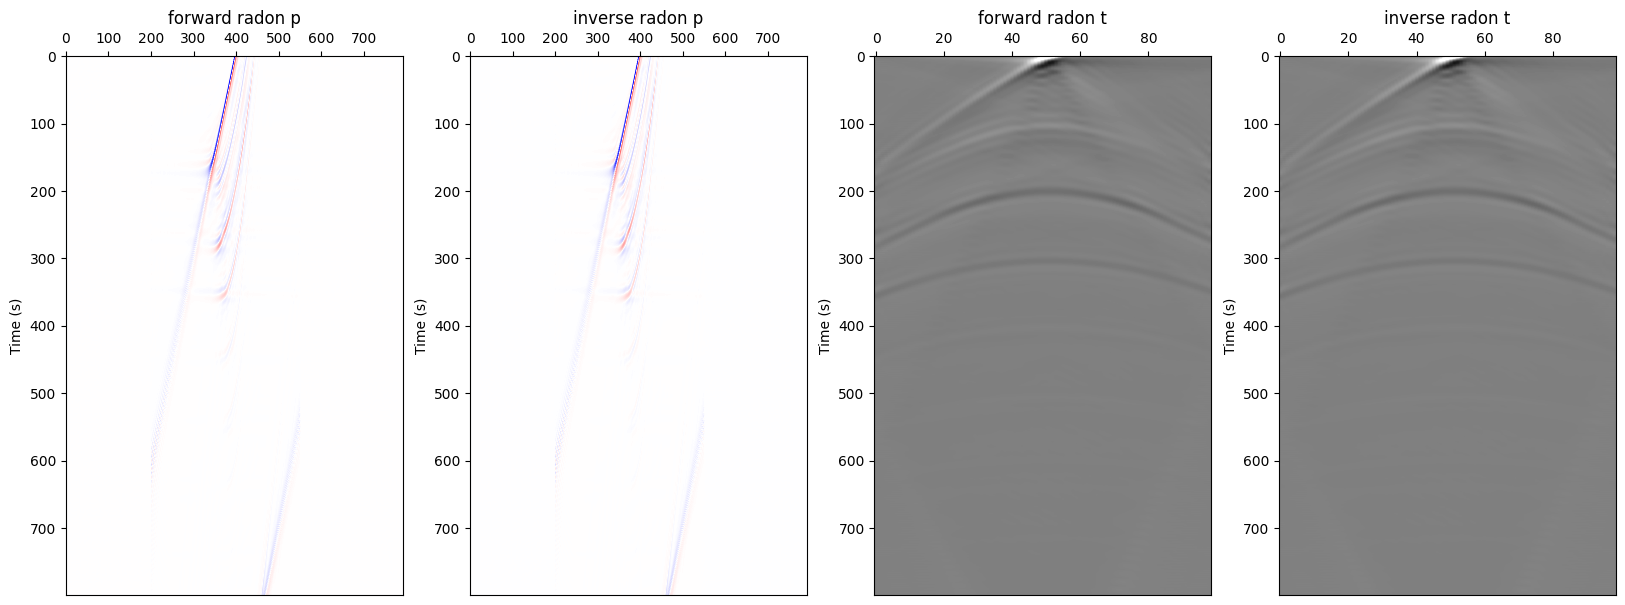

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(20, 7))
axs[0].imshow(
    dL_p_filter,
    cmap="bwr_r",
    vmin=-pclip * np.abs(dL_p_filter).max(),
    vmax=pclip * np.abs(dL_p_filter).max(),
)
axs[0].set(ylabel="Time (s)", title="forward radon p")
axs[0].xaxis.set_ticks_position('top')
axs[0].axis("tight")

axs[1].imshow(
    dL_t_filter,
    cmap="bwr_r",
    vmin=-pclip * np.abs(dL_t_filter).max(),
    vmax=pclip * np.abs(dL_t_filter).max(),
)
axs[1].set(ylabel="Time (s)", title="inverse radon p")
axs[1].xaxis.set_ticks_position('top')
axs[1].axis("tight")

axs[2].imshow(
    dL_p_inverse_filter.T,
    cmap="gray",
    vmin=-pclip * np.abs(dL_p_inverse_filter).max(),
    vmax=pclip * np.abs(dL_p_inverse_filter).max(),
)
axs[2].set(ylabel="Time (s)", title="forward radon t")
axs[2].xaxis.set_ticks_position('top')
axs[2].axis("tight")

axs[3].imshow(
    dL_t_inverse_filter.T,
    cmap="gray",
    vmin=-pclip * np.abs(dL_t_inverse_filter).max(),
    vmax=pclip * np.abs(dL_t_inverse_filter).max(),
)
axs[3].set(ylabel="Time (s)", title="inverse radon t")
axs[3].xaxis.set_ticks_position('top')
axs[3].axis("tight")

(np.float64(0.0), np.float64(99.0), np.float64(0.8), np.float64(0.0))

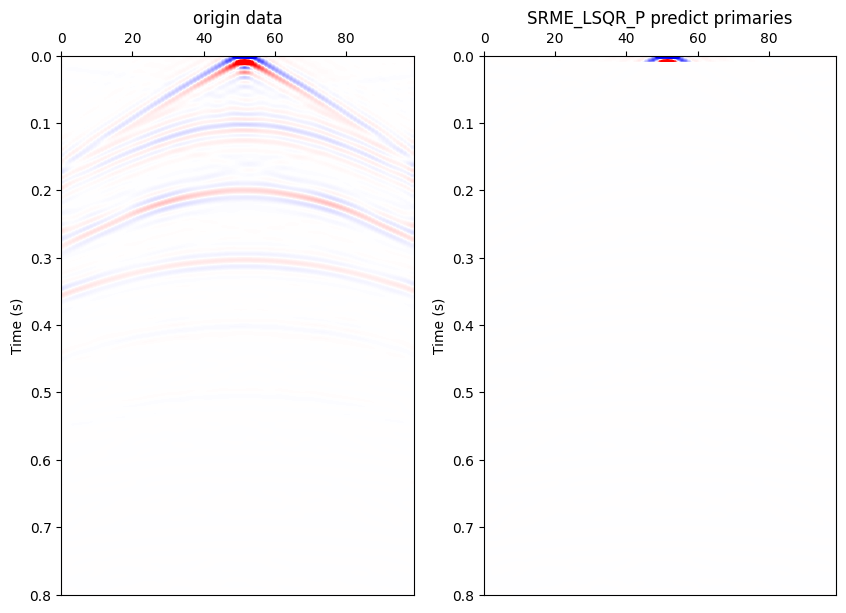

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

pclip = 0.2
axs[0].imshow(
    focal_forward_p[isrc, :, :].T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(focal_forward_p[isrc, :, :]).max(),
    vmax=pclip * np.abs(focal_forward_p[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[0].set(ylabel="Time (s)", title="origin data")
axs[0].xaxis.set_ticks_position('top')
axs[0].axis("tight")

focal_forward = focal_forward_p.copy()
focal_forward[:, :, 10:] *= 1e-3

axs[1].imshow(
    focal_forward[isrc, :, :].T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(focal_forward[isrc, :, :]).max(),
    vmax=pclip * np.abs(focal_forward[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[1].set(ylabel="Time (s)", title="SRME_LSQR_P predict primaries")
axs[1].xaxis.set_ticks_position('top')
axs[1].axis("tight")

In [16]:
from uilts.focal_transform import focal_transform_inverse

print(lsqr_prim_p.shape)
print(focal_forward_p.shape)

focal_inverse_p = focal_transform_inverse(focal_forward, lsqr_prim_p, 1e-4)

(99, 99, 800)
(99, 99, 800)


inverse: 100%|█████████████████████████████████████████████████| 1025/1025 [00:02<00:00, 425.80it/s]


In [17]:
from uilts.adasubtraction import adasubtraction_lsqr

nwin = (7, 11)
prim, multiples = adasubtraction_lsqr(focal_inverse_p, data_mutter, nwin, 2e2, 1e2)

 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588 594 600 606 612 618 624 630 636 642
 648 654 660 666 672 678 684 690 696 702 708 714 720 726 732 738 744 750
 756 762 768 774 780 786], end:[ 11  17  23  29  35  41  47  53  59  65  71  77  83  89  95 101 107 113
 119 125 131 137 143 149 155 161 167 173 179 185 191 197 203 209 215 221
 227 233 239 245 251 257 263 269 275 281 287 293 299 305 311 317 323 329
 335 341 347 353 359 365 371 377 383 389 395 401 407 413 419 425 431 437
 443 449 455 461 467 473 479 485 491 497 503 509 515 521 527 533 539 545
 551 557 563 569 575 581 587 593 599 605 611 617 623 629 635 641 647 653
 659 665 671 677 683 689 695 701 707 713 719 725 731 737 743 749 755 761
 767 773 779 785 791

KeyboardInterrupt: 

(np.float64(0.0), np.float64(99.0), np.float64(0.8), np.float64(0.0))

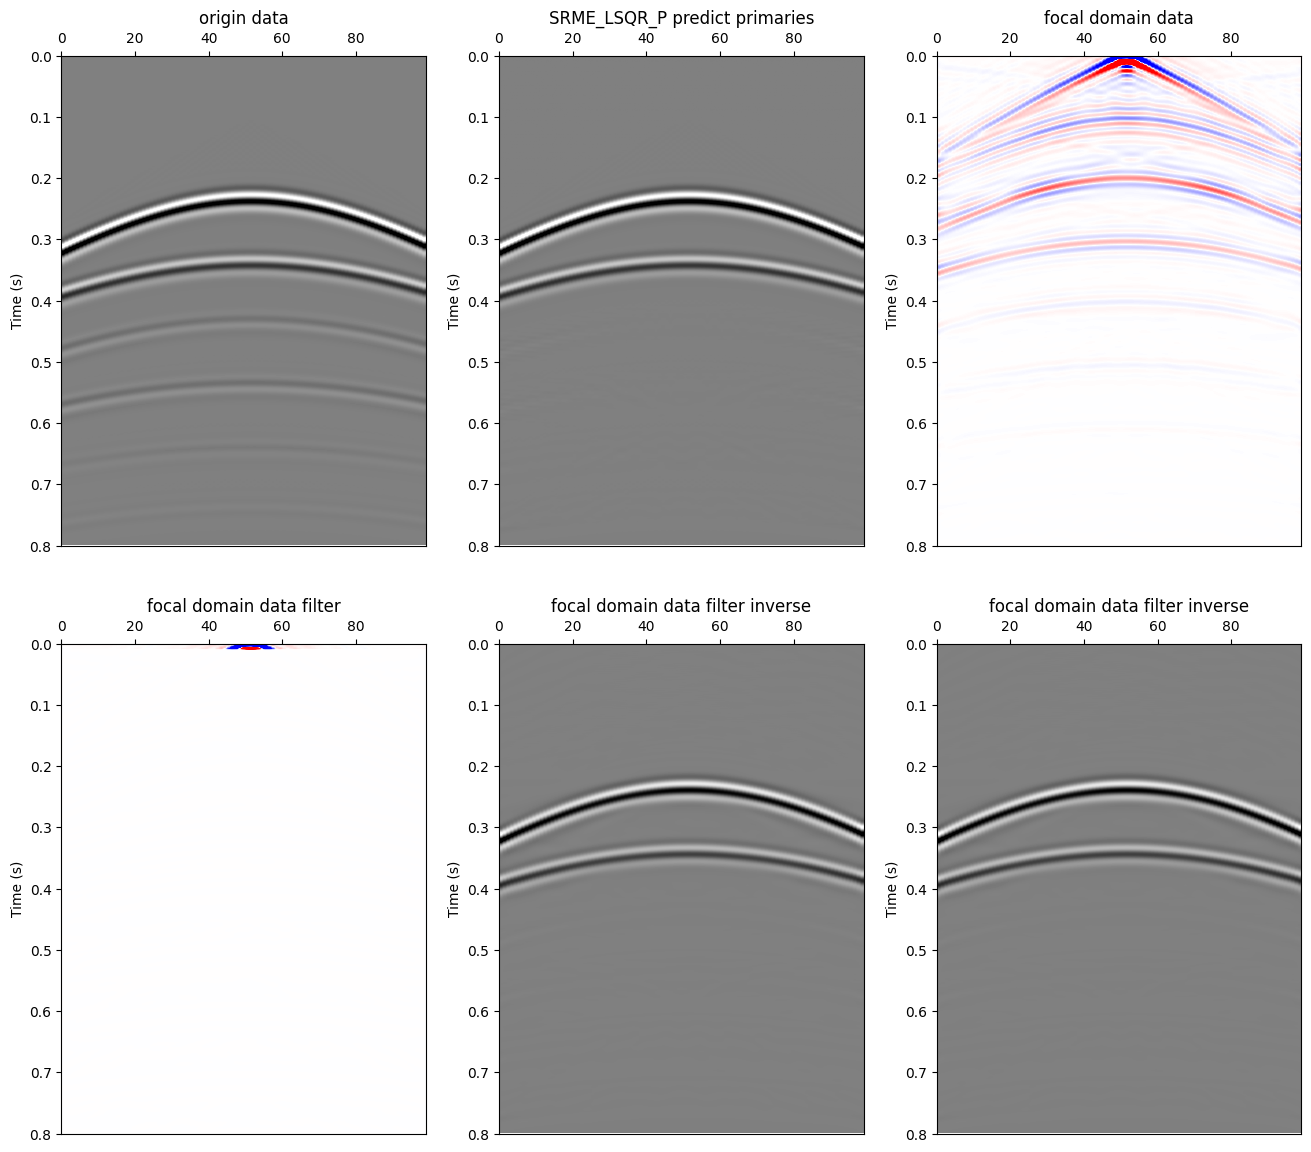

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(16, 14))

pclip = 0.7
axs[0, 0].imshow(
    data_mutter[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(data_mutter[isrc, :, :]).max(),
    vmax=pclip * np.abs(data_mutter[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[0, 0].set(ylabel="Time (s)", title="origin data")
axs[0, 0].xaxis.set_ticks_position('top')
axs[0, 0].axis("tight")

axs[0, 1].imshow(
    lsqr_prim_p[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(lsqr_prim_p[isrc, :, :]).max(),
    vmax=pclip * np.abs(lsqr_prim_p[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[0, 1].set(ylabel="Time (s)", title="SRME_LSQR_P predict primaries")
axs[0, 1].xaxis.set_ticks_position('top')
axs[0, 1].axis("tight")

axs[0, 2].imshow(
    focal_forward_p[isrc, :, :].T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(focal_forward_p[isrc, :, :]).max() * 0.1,
    vmax=pclip * np.abs(focal_forward_p[isrc, :, :]).max() * 0.1,
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[0, 2].set(ylabel="Time (s)", title="focal domain data")
axs[0, 2].xaxis.set_ticks_position('top')
axs[0, 2].axis("tight")

axs[1, 0].imshow(
    focal_forward[isrc, :, :].T,
    cmap="bwr_r",
    vmin=-pclip * np.abs(focal_forward[isrc, :, :]).max() * 0.1,
    vmax=pclip * np.abs(focal_forward[isrc, :, :]).max() * 0.1,
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[1, 0].set(ylabel="Time (s)", title="focal domain data filter")
axs[1, 0].xaxis.set_ticks_position('top')
axs[1, 0].axis("tight")

axs[1, 1].imshow(
    focal_inverse_p[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(focal_inverse_p[isrc, :, :]).max(),
    vmax=pclip * np.abs(focal_inverse_p[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[1, 1].set(ylabel="Time (s)", title="focal domain data filter inverse")
axs[1, 1].xaxis.set_ticks_position('top')
axs[1, 1].axis("tight")

axs[1, 2].imshow(
    prim[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(prim[isrc, :, :]).max(),
    vmax=pclip * np.abs(prim[isrc, :, :]).max(),
    extent=(0, nr, nt * dt * 1e-3, 0),
)
axs[1, 2].set(ylabel="Time (s)", title="focal domain data filter inverse")
axs[1, 2].xaxis.set_ticks_position('top')
axs[1, 2].axis("tight")